### **Exploratory Data Analysis**

In [1]:
# IMPORTS

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import kendalltau, chi2_contingency
import seaborn as sns

In [2]:
# LOAD DATASET

df = pd.read_csv("drug_consumption.csv")
# Remove records claiming use of "Semeron" (fake drug to identify drug seekers)
df = df[df['semer'] == 'CL0']
feature_file_dict = {f"{feat}":f"additional-variable-information/{i}-{feat}.csv" for i,feat in enumerate(df.columns.to_list())}
# Categorize all feature variables by data types
all_vars = df.columns.tolist()

input = ['age', 'gender', 'education', 'country', 'ethnicity', 'n_score', 'e_score', 'o_score', 'a_score', 'c_score']
target = ['alcohol', 'amphet', 'amyl', 'benzos', 'caff', 'cannabis', 'choc', 'coke', 'crack', 'ecstasy', 'heroin', 'ketamine', 'legalh', 'lsd', 'meth', 'mushrooms', 'nicotine', 'vsa']
nominal = ['gender', 'country', 'ethnicity']
ordinal = ['age', 'education', 'alcohol', 'amphet', 'amyl', 'benzos', 'caff', 'cannabis', 'choc', 'coke', 'crack', 'ecstasy', 'heroin', 'ketamine', 'legalh', 'lsd', 'meth', 'mushrooms', 'nicotine', 'vsa']
discrete = ['n_score', 'e_score', 'o_score', 'a_score', 'c_score']

demographic_vars = [v for v in set(input) if v in (nominal+ordinal)]
drug_vars = ['alcohol', 'amphet', 'amyl', 'benzos', 'caff', 'cannabis', 'choc', 'coke', 'crack', 'ecstasy', 'heroin', 'ketamine', 'legalh', 'lsd', 'meth', 'mushrooms', 'nicotine', 'vsa']

In [3]:
# CONVERT FEATURE VALUES TO MEANINGS (FOR READABILITY)
ordered_meanings = {}
# Convert feature values with each variable value's corresponding meaning
for var in demographic_vars:
    df_var = pd.read_csv(feature_file_dict[var], usecols=['Value', 'Meaning'])
    value_meanings = pd.Series(df_var['Meaning'].values, index=df_var['Value']).to_dict()
    ordered_meanings[var]=list(value_meanings.values())
    df[var] = df[var].map(value_meanings)
for var in discrete:
    score_col = f"{var[0].capitalize()}score"
    df_score = pd.read_csv(feature_file_dict[var], usecols=[score_col, 'Value'])
    value_scores = pd.Series(df_score[score_col].values, index=df_score['Value']).to_dict()
    df[var] = df[var].map(value_scores)

#### **Initial Visualizations**

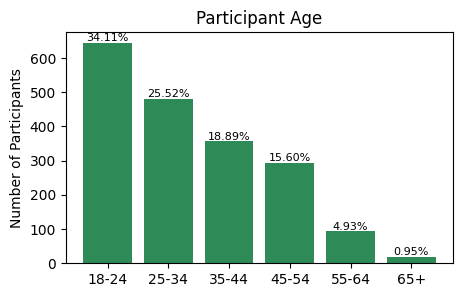

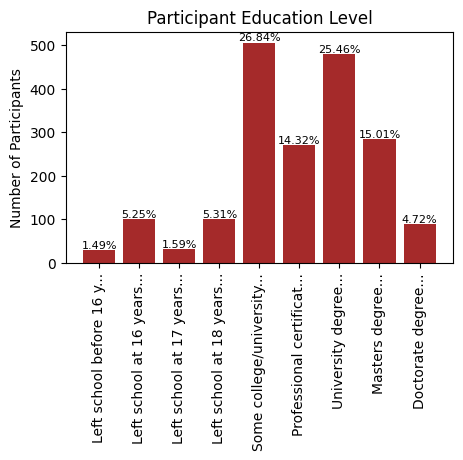

In [ ]:
# ORDINAL (CATEGORICAL)

# Visualize the ordinal feature distributions
# Age Visual
fig1, ax1 = plt.subplots(figsize=(5,3))
age = pd.read_csv(feature_file_dict['age'], usecols=['Cases', 'Meaning', 'Fraction'])
ax1.set_ylabel("Number of Participants")
ax1.set_title("Participant Age")
age_chart = ax1.bar(x=age.Meaning, height=age.Cases, color='seagreen')
ax1.bar_label(age_chart, labels=age.Fraction, fontsize=8)
plt.show()
# Education Level Visual
fig2, ax2 = plt.subplots(figsize=(5,3))
edu = pd.read_csv(feature_file_dict['education'], usecols=['Cases', 'Meaning', 'Fraction'])
edu['Meaning'] = edu['Meaning'].apply(lambda x: x[:23]+"...")
ax2.tick_params(axis='x', labelrotation=90)
ax2.set_ylabel("Number of Participants")
ax2.set_title("Participant Education Level")
edu_chart = ax2.bar(x=edu.Meaning, height=edu.Cases, color='brown')
ax2.bar_label(edu_chart, labels=edu.Fraction, fontsize=8)
plt.show()

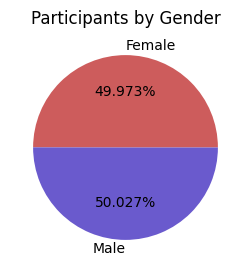

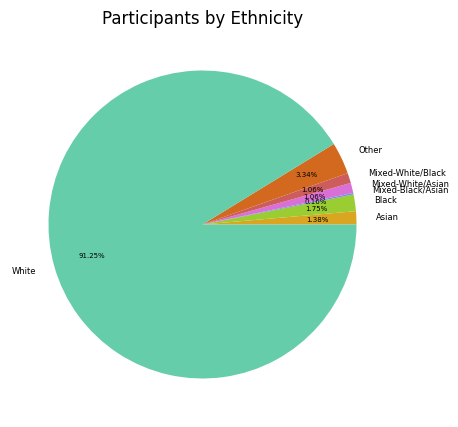

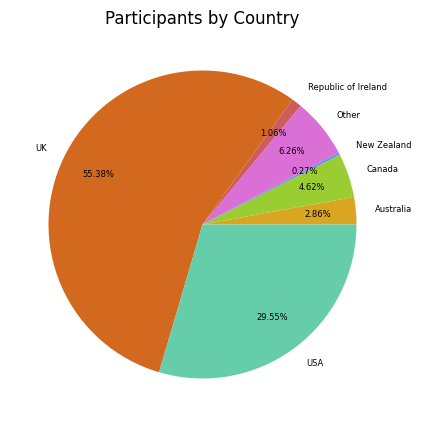

In [ ]:
# NOMINAL (CATEGORICAL)

# Visualize the nominal feature distributions
# Gender Visual
fig3, ax3 = plt.subplots(figsize=(5,3))
gender = pd.read_csv(feature_file_dict['gender'], usecols=['Cases', 'Meaning'])
ax3.set_title("Participants by Gender")
gender_chart = ax3.pie(gender.Cases, labels=gender.Meaning, autopct='%1.3f%%',
                       colors=['indianred', 'slateblue'])
plt.show()
# Ethnicity Visual
fig4, ax4 = plt.subplots(figsize=(5,5))
eth = pd.read_csv(feature_file_dict['ethnicity'], usecols=['Cases', 'Meaning'])
ax4.set_title("Participants by Ethnicity")
eth_pie, eth_labels, eth_pc = ax4.pie(eth.Cases, labels=eth.Meaning, autopct='%1.2f%%', labeldistance=1.125,
                                      pctdistance=0.75,
                                      colors=['goldenrod', 'yellowgreen', 'cornflowerblue', 'orchid','indianred', 'chocolate', 'mediumaquamarine'])
plt.setp(eth_pc, fontsize=5)
plt.setp(eth_labels, fontsize=6)
plt.show()
# Country Visual
fig5, ax5 = plt.subplots(figsize=(5,5))
country = pd.read_csv(feature_file_dict['country'], usecols=['Cases', 'Meaning'])
ax5.set_title("Participants by Country")
country_pie, country_labels, country_pc = ax5.pie(country.Cases, labels=country.Meaning, labeldistance=1.125,
                                                  autopct='%1.2f%%', pctdistance=0.75,
                                                  colors=['goldenrod', 'yellowgreen', 'cornflowerblue', 'orchid','indianred', 'chocolate', 'mediumaquamarine'])
plt.setp(country_pc, fontsize=6)
plt.setp(country_labels, fontsize=6)
plt.show()

#### **Pairwise Correlation Matrix**

In [ ]:
# CONVERT DRUG VALUES

# Handle CL[1-9] values used to indicate recency of drug use with a NON-LINEAR (exponential) scale to emphasize recency
drug_class_map = {f'CL{i}': 2**i for i in range(7)}
for drug in drug_vars:
    df[drug] = df[drug].map(drug_class_map) 

In [ ]:
# DEFINE CORRELATION FUNCTIONS

# Cramer's V (Nominal-nominal pair)
# https://stackoverflow.com/questions/46498455/categorical-features-correlation/46498792#46498792
def cramers_v_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.values.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

def cramers_v(a, b):
    confusion_matrix = pd.crosstab(a, b)
    return cramers_v_stat(confusion_matrix)

def correlation_ratio(categories, measurements):
    categories = pd.Categorical(categories)
    cat_num = len(categories.categories)
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i, cat in enumerate(categories.categories):
        cat_measures = measurements[categories == cat]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.mean(cat_measures) if len(cat_measures) > 0 else 0
    y_total_avg = np.sum(y_avg_array * n_array) / np.sum(n_array)
    numerator = np.sum(n_array * (y_avg_array - y_total_avg) ** 2)
    denominator = np.sum((measurements - y_total_avg) ** 2)
    if denominator == 0:
        return 0.0
    else:
        return np.sqrt(numerator / denominator)

In [ ]:
# BUILD MATRIX

def to_numeric_series(series):
    """Convert a categorical series to numeric codes if not already numeric."""
    if pd.api.types.is_numeric_dtype(series):
        return series
    return pd.Series(pd.Categorical(series).codes, index=series.index)

matrix_vars = nominal_vars + ordinal_vars + personality_vars
corr_matrix = pd.DataFrame(np.nan, index=matrix_vars, columns=matrix_vars)
strong_c = 0
var_s1 = var_s2 = ""
# Fill matrix with values
for i, var1 in enumerate(matrix_vars):
    for j, var2 in enumerate(matrix_vars):
        if i > j:
            continue  # Fill upper triangle only
        if var1 == var2:
            corr_matrix.loc[var1, var2] = 1.0
        elif var1 in personality_vars and var2 in personality_vars: # Use Kendall's tau for numeric-numeric
            tau, _ = kendalltau(df[var1], df[var2])
            corr_matrix.loc[var2, var1] = tau
            if np.abs(tau) > strong_c:
                strong_c = tau
                var_s1, var_s2 = var1, var2
        elif (var1 in personality_vars and var2 in ordinal_vars) or (var2 in personality_vars and var1 in ordinal_vars):    # Use Kendall's tau for numeric-ordinal
            tau, _ = kendalltau(df[var1], df[var2])
            corr_matrix.loc[var2, var1] = tau
            if np.abs(tau) > strong_c:
                strong_c = tau
                var_s1, var_s2 = var1, var2
        elif var1 in ordinal_vars and var2 in ordinal_vars: # Use Kendall's tau for ordinal-ordinal
            tau, _ = kendalltau(df[var1], df[var2])
            corr_matrix.loc[var2, var1] = tau
            if np.abs(tau) > strong_c:
                strong_c = tau
                var_s1, var_s2 = var1, var2
        elif var1 in nominal_vars and var2 in nominal_vars: # Use Cramér's V for nominal-nominal
            v = cramers_v(df[var1], df[var2])
            corr_matrix.loc[var2, var1] = v
            if np.abs(v) > strong_c:
                strong_c = v
                var_s1, var_s2 = var1, var2
        else:   # Mixed: nominal with numeric or ordinal (use correlation ratio)
            if var1 in nominal_vars:
                eta = correlation_ratio(to_numeric_series(df[var1]), to_numeric_series(df[var2]))
            else:
                eta = correlation_ratio(to_numeric_series(df[var2]), to_numeric_series(df[var1]))
            corr_matrix.loc[var2, var1] = eta
            if np.abs(eta) > strong_c:
                strong_c = eta
                var_s1, var_s2 = var1, var2 # Visualize complete pairwise correlation matrix
corr_matrix = corr_matrix.round(2)
print(f"Strongest correlation (+/-): \nVariable 1: {var_s1.title()}\nVariable 2: {var_s2.title()} \nValue: {strong_c:.3f}")
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, annot_kws={"fontsize": 5}, cmap="coolwarm", center=0, square=True)
plt.title("Mixed-Type Pairwise Correlation Matrix")
plt.tight_layout()
plt.show()

In [ ]:
# Correlation Matrix Interpretation
# 1. There're no feature pairs with near-perfect correlation 
#    (abs[corr] >= 0.8), so we shouldn't drop features 
#    to avoid redundancy. Moreover, no features have an 
#    extremely strong relationship with many others, so we 
#    can/should keep most/all features.
# 2. Linear models will not generate great results with these
#    features, so we should progress as advised in lecture to
#    use tree-based or other non-linear models.